In [1]:
(require '[clojupyter.misc.helper :as helper])
(helper/add-dependencies '[incanter "1.9.3"])
(use '(incanter core stats charts io datasets optimize))
:ok

:ok

In [2]:
(defn sample-dataset
  "Create a random sample of a dataset's row"
  [column-name percent dataset]
  ($where {column-name {:$fn (fn [_] (< (rand) percent))}} dataset))
:ok

:ok

In [3]:
(def customers (read-dataset "customer_data.csv" :header true))
(def reps (read-dataset "rep_data.csv" :header true))
(def engagements (read-dataset "engagement_data.csv" :header true))
(def smengagements (sample-dataset 0 0.001 engagements))
[(nrow engagements), (nrow smengagements)]


[421570 440]

In [4]:
(defn from-customer
    "Join to find the column from customer data"
    [column-name dataset]
  ($ column-name
    ($join [:customer_id :customer_id] customers dataset)))

(defn from-customer-rep
  "Join to find a row value based on customer ID and rep ID together. Map any nils to 0.0"
  [column-name dataset]
    ($map #(or % 0.0) column-name
      ($join [[:customer_id :repid] [:customer_id :rep-id]] reps dataset)))
:ok

:ok

In [5]:
(def input-data
  (add-derived-column
    :hit-target [:target_deal_size :actual_deal_size] <=
      (rename-cols
        {0 :customer_id
         1 :industry_id
         2 :target_deal_size
         3 :engagement_type_id
         4 :channel_spend1
         5 :channel_spend2
         6 :channel_spend3
         7 :channel_spend4
         8 :channel_spend5
         9 :num_engagements
         10 :actual_deal_size
         11 :prior_contact
         12 :initial_channel_type}
      (conj-cols
        ($ :customer_id smengagements)
        (from-customer :industry_id smengagements)
        (from-customer :target_deal_size smengagements)
        ($ :engagement_type_id smengagements)
        (from-customer-rep :channel_spend1 smengagements)
        (from-customer-rep :channel_spend2 smengagements)
        (from-customer-rep :channel_spend3 smengagements)
        (from-customer-rep :channel_spend4 smengagements)
        (from-customer-rep :channel_spend5 smengagements)
        (from-customer-rep :num_engagements smengagements)
        ($ :actual_deal_size smengagements)
        ($ :prior_contact smengagements)
        ($ :initial_channel_type smengagements)))))
(print (nrow input-data))
input-data

440


| :customer_id | :industry_id | :target_deal_size | :engagement_type_id | :channel_spend1 | :channel_spend2 | :channel_spend3 | :channel_spend4 | :channel_spend5 | :num_engagements | :actual_deal_size | :prior_contact | :initial_channel_type | :hit-target |
|--------------+--------------+-------------------+---------------------+-----------------+-----------------+-----------------+-----------------+-----------------+------------------+-------------------+----------------+-----------------------+-------------|
|    Customer1 |    Industry1 |           2081200 |             Medium7 |         2585.85 |           31.75 |            10.0 |         1057.16 |         1305.01 |               11 |           1630900 |          False |             HighTouch |       false |
|    Customer1 |    Industry1 |           2081200 |             Medium8 |         2585.85 |           31.75 |            10.0 |         1057.16 |         1305.01 |               11 |           3531800 |          False |      

In [43]:
(defn map-feature
  "Return 1 if the row value matches the given value, or 0"
  [from-column value dataset]
  ($map #(if (= % value) 1 0) from-column dataset))

(defn create-input-matrix
  "Pull out the values we're interested in, and convert them to numeric values"
  [input-matrix]
    (to-matrix
    (conj-cols
      (map-feature :industry_id "Industry1" input-data)
      (map-feature :industry_id "Industry2" input-data)
      (map-feature :industry_id "Industry3" input-data)
      ($ :channel_spend1 input-data)
      ($ :channel_spend2 input-data)
      ($ :channel_spend3 input-data)
      ($ :channel_spend4 input-data)
      ($ :channel_spend5 input-data)
      ($ :num_engagements input-data)
      (map-feature :prior_contact "True" input-data)
      (map-feature :initial_channel_type "HighTouch" input-data))))

(def input-matrix (create-input-matrix smengagements))
(def init-coefs (repeat (ncol input-matrix) 0.0))
(def y-values (map-feature :hit-target true input-data))
(println init-coefs)
(println y-values)
(take 10 input-matrix)

(0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0)
(0 1 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 1 0 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 1 0 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 1 0 0 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 1 0 1 1 1 0 1 0 0 0 1 0 0 1 0 0 1 0 0 0 0 0 1 0 1 0 1 1 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 1 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 0 1 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 0 1 0 0 0 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 1 1 0 1 0 0 1 1 0)


(#vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,1.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,0.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,1.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,1.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,0.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,0.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,0.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,0.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,0.0] #vectorz/array [1.0,0.0,0.0,2585.85,31.75,10.0,1057.16,1305.01,11.0,0.0,1.0])

In [7]:
;; ;; Taking the logistic regression implementation from
;; ;; https://subscription.packtpub.com/book/big_data_and_business_intelligence/9781784397180/4/ch04lvl1sec86/implementing-logistic-regression-with-incanter

;; (defn sigmoid-function
;;   "compute the inverse logit function, large positive numbers should be
;;   close to 1, large negative numbers near 0,
;;   z can be a scalar, vector or matrix.
;;   sanity check: (sigmoid 0) should always evaluate to 0.5"
;;   [coefs]
;;   (let [bt (incanter.core/trans coefs)
;;         z  (fn [x] (- (first (incanter.core/mmult bt x))))]
;;     (fn [x]
;;       (/ 1
;;          (+ 1
;;             (incanter.core/exp (z x)))))))

;; ;; [((sigmoid-function [0]) 0)
;; ;; ((sigmoid-function [0]) -1)
;; ;; ((sigmoid-function [0]) 42)
;; ;; ((sigmoid-function [0.2]) 5)
;; ;; ((sigmoid-function [-0.2]) 5)]
;; ;; [0.5 0.5 0.5 0.7310585786300049 0.2689414213699951]

;; (defn logistic-cost [ys y-hats]
;;   "This pair of functions captures the intuition that, if y-hat = 0 but y = 1,
;;   then the model should be penalized by a very large cost.
;;   Symmetrically, the model should also be heavily penalized if
;;   y-hat = 1 and y = 0. Where the model closely agrees with the data, the cost
;;   falls steeply towards zero.

;;   This is the cost for an individual training point. To combine the individual
;;   costs and calculate an overall cost for a given vector of coefficients and a
;;   set of training data, we can simply take the average across all the training
;;   examples"
;;   (let [cost (fn [y y-hat]
;;                (if (zero? y)
;;                  (- (log (- 1 y-hat)))
;;                  (- (log y-hat))))]
;;     (println (map cost ys y-hats))
;;     (mean (map cost ys y-hats))))

;; ;; [(logistic-cost [0 0 1 1] [0 0 1 1])
;; ;; (logistic-cost [0.1 0.1 1 1] [0.1 0.1 0.1 1])
;; ;; (logistic-cost [0.1 0.1 1 1] [1 0.1 1 0.1])]
;; ;; [0.0 1.7269388197455342 1.1512925464970227]

;; (defn logistic-regression [ys xs]
;;   "Define a logistic regression using Incanter's minimize function. The cost-fn
;;   accepts a matrix of coefficients. We create a classifier from the coefficients
;;   using the sigmoid-function previously defined, and a sequence of predictions,
;;   y-hats, based on the input data. Finally, we can calculate and return the
;;   logistic-cost value based on the provided coefficients.

;;   To perform logistic regression, we minimize the logistic cost-fn by selecting
;;   the optimal parameters to the sigmoid-function. Since we have to start somewhere,
;;   our initial coefficients are simply 0.0 for each parameter."
;;   (let [cost-fn (fn [coefs]
;;                   (let [classify (sigmoid-function coefs)
;;                         y-hats   (map (comp classify trans) xs)]
;;                     (logistic-cost ys y-hats)))
;;         init-coefs (repeat (ncol xs) 0.0)]
;;     (minimize cost-fn init-coefs)))
;; :ok
;; ;; ((sigmoid-function [0.2 0.2 0.2 0.2 0.2]) [1 1 1 1 1])

In [8]:
;; (let [xs input-matrix
;;   ys (map-feature :hit-target true input-data)
;;   coefs (logistic-regression ys xs)
;; ;;   classifier (comp logistic-class
;; ;;     (sigmoid-function coefs)
;; ;;     i/trans)
;;       ]
;; ;;   (println "Observed: " (map int (take 10 ys)))
;; ;;   (println "Predicted:" (map classifier (take 10 xs)))
;;   coefs
;;   )


In [40]:
;;  (defn- sigmoid
;;    "compute the inverse logit function, large positive numbers should be
;;  close to 1, large negative numbers near 0,
;;  z can be a scalar, vector or matrix.
;;  sanity check: (sigmoid 0) should always evaluate to 0.5"
;;    [z]
;;    (div 1 (plus 1 (exp (minus z)))))
 
;;   (defn- cost-func
;;    "computes the cost function (J) that will be minimized
;;     inputs: initial-thetas X matrix and Y vector"
;;    [[init-vals X y]]
;;    (let
;;        [m (nrow X)
;;         z (mmult X init-vals)
;;         h (sigmoid z)
;;         J (plus
;;             (mult (div (minus 1) m) (mmult (trans y) (matrix (log h))))
;;             (mmult (minus 1.0 (trans y)) (log (minus 1.0 h))))]
;;      J))

;; (let [xs input-matrix
;;       ys (map-feature :hit-target true input-data)
;;       coefs (repeat (ncol xs) 0.0)]
;;   (minimize cost-func coefs))

Execution error (IllegalArgumentException) at user/cost-func (REPL:14).
No method in multimethod 'nrow' for dispatch value: class java.lang.Double


class java.lang.IllegalArgumentException: 

In [88]:
(defn sigmoid
  "compute the inverse logit function, large positive numbers should be
  close to 1, large negative numbers near 0,
  z can be a scalar, vector or matrix.
  sanity check: (sigmoid 0) should always evaluate to 0.5"
  [z]
  (/ 1
     (+ 1
        (Math/exp (- z)))))

(def target (map sigmoid y-values))

(defn weights
  "Do the regression, finding the error each round and adjusting the weights"
  [coefs c mat]
  (let [alpha 0.0001
        good-enough 0.01
        halt 1000
        error (minus target (map sigmoid (mmult mat coefs)))
        stop-values (plus coefs (mult alpha (mmult (trans mat) error)))]
    (println (mean error))

  ;; Stop if the total error is less than the threshold, or we run out of iterations
  (if (or
        (< (Math/abs (mean error)) good-enough)
        (> (+ c 1) halt))
    coefs
    (weights stop-values (+ c 1) mat))))

(weights init-coefs 1 input-matrix)

0.07876996998750177
-0.42123003001249854
0.5787699699875023
-0.42123003001249854
0.5787699699875023
-0.42123003001249854
-0.42123003001249854
0.5787699699875023
-0.42123003001249854
0.5787699699875023
-0.42123003001249854
-0.009866393648861877


[0.002262279212807368 -0.005570929230800837 -0.002566684508055953 1.7220879040627324 0.176181018426546 0.16483370018151988 -0.4678084336411885 -4.252182568420643 -0.06634555162918526 -7.125200715629484E-4 -0.004125200715629699]

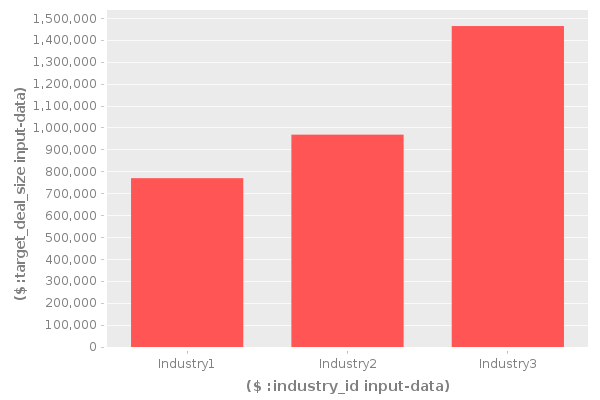

In [10]:
(->  (bar-chart ($ :industry_id input-data)
                ($ :target_deal_size input-data))
  (.createBufferedImage 600 400))

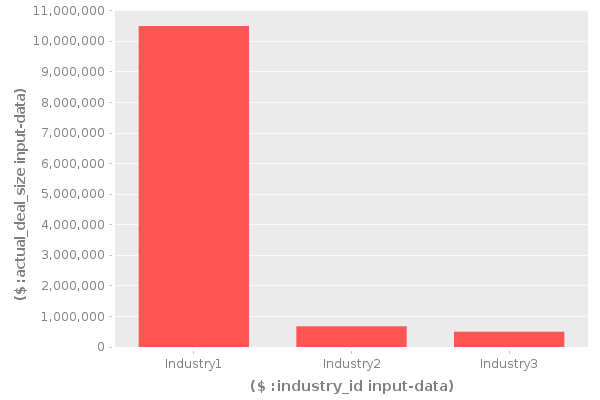

In [11]:
(->  (bar-chart ($ :industry_id input-data)
                ($ :actual_deal_size input-data))
  (.createBufferedImage 600 400))

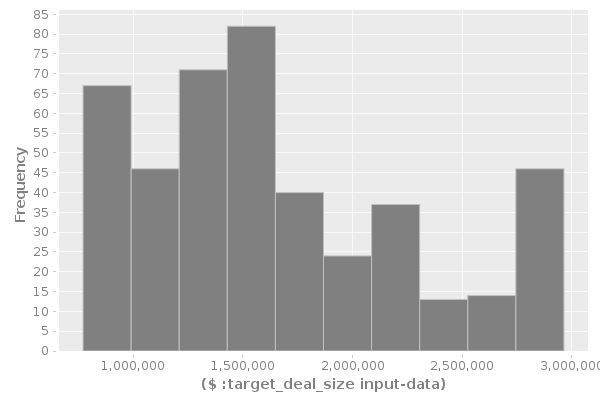

In [12]:
(->  ($ :target_deal_size input-data)
  histogram
  (.createBufferedImage 600 400))

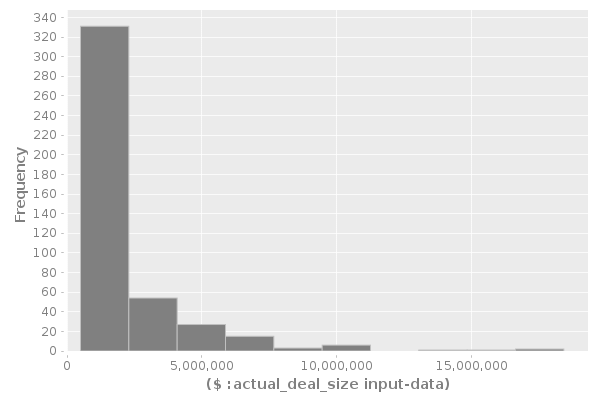

In [13]:
;; (sample-normal 1000)
(->  ($ :actual_deal_size input-data)
  histogram
  (.createBufferedImage 600 400))

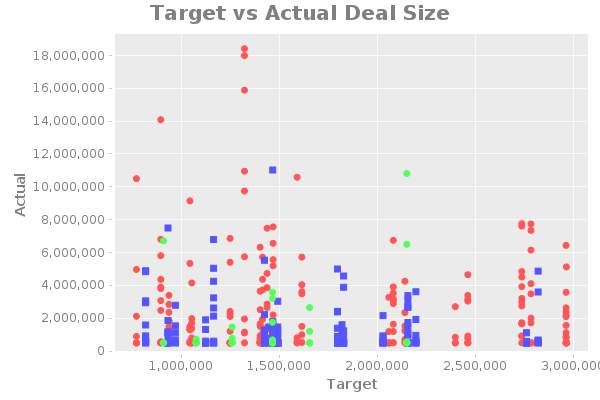

In [14]:
(-> (scatter-plot
      ($ :target_deal_size input-data)
      ($ :actual_deal_size input-data)
      :title "Target vs Actual Deal Size"
      :x-label "Target"
      :y-label "Actual"
      :group-by ($ :industry_id input-data))
  (.createBufferedImage 600 400))

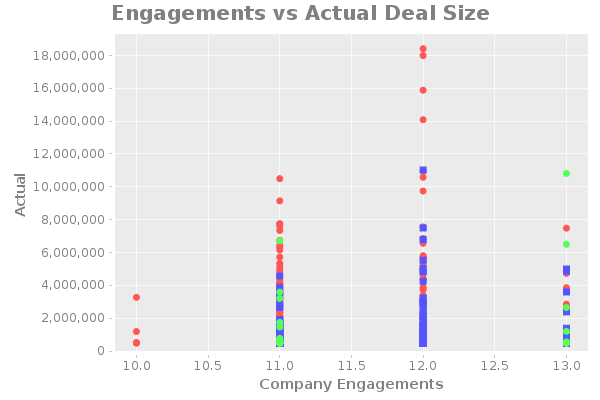

In [15]:
(-> (scatter-plot
      ($ :num_engagements input-data)
      ($ :actual_deal_size input-data)
      :title "Engagements vs Actual Deal Size"
      :x-label "Company Engagements"
      :y-label "Actual"
      :group-by ($ :industry_id input-data))
  (.createBufferedImage 600 400))

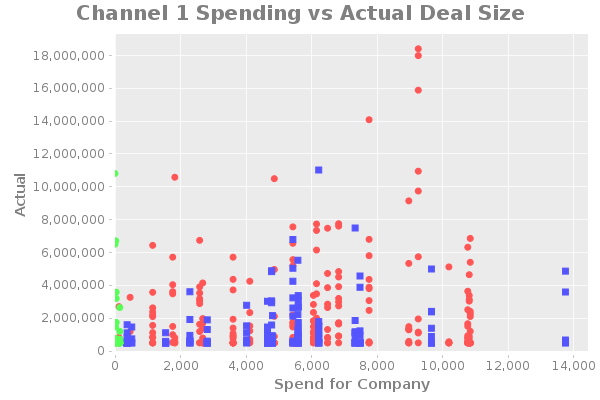

In [16]:
(-> (scatter-plot
      ($ :channel_spend1 input-data)
      ($ :actual_deal_size input-data)
      :title "Channel 1 Spending vs Actual Deal Size"
      :x-label "Spend for Company"
      :y-label "Actual"
      :group-by ($ :industry_id input-data))
  (.createBufferedImage 600 400))

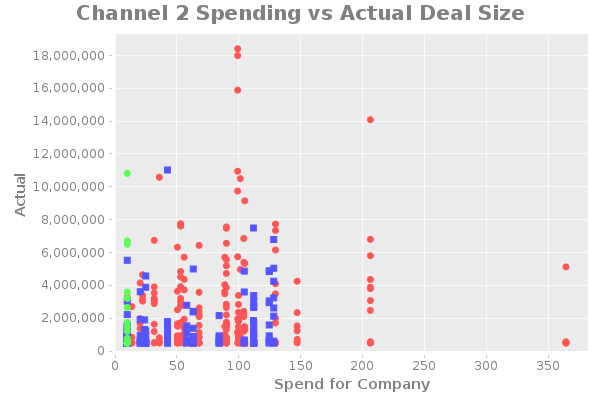

In [17]:
(-> (scatter-plot
    ($ :channel_spend2 input-data)
    ($ :actual_deal_size input-data)
    :title "Channel 2 Spending vs Actual Deal Size"
    :x-label "Spend for Company"
    :y-label "Actual"
    :group-by ($ :industry_id input-data))
  (.createBufferedImage 600 400))

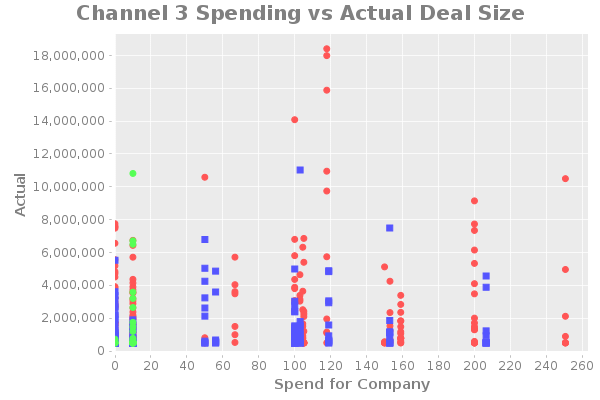

In [18]:
(-> (scatter-plot
    ($ :channel_spend3 input-data)
    ($ :actual_deal_size input-data)
    :title "Channel 3 Spending vs Actual Deal Size"
    :x-label "Spend for Company"
    :y-label "Actual"
    :group-by ($ :industry_id input-data))
  (.createBufferedImage 600 400))

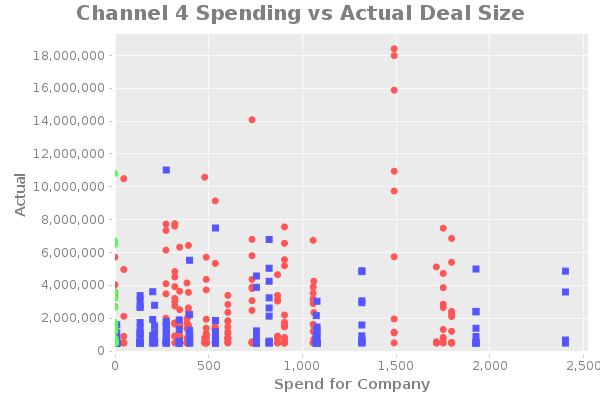

In [19]:
(-> (scatter-plot
      ($ :channel_spend4 input-data)
      ($ :actual_deal_size input-data)
      :title "Channel 4 Spending vs Actual Deal Size"
      :x-label "Spend for Company"
      :y-label "Actual"
      :group-by ($ :industry_id input-data))
  (.createBufferedImage 600 400))

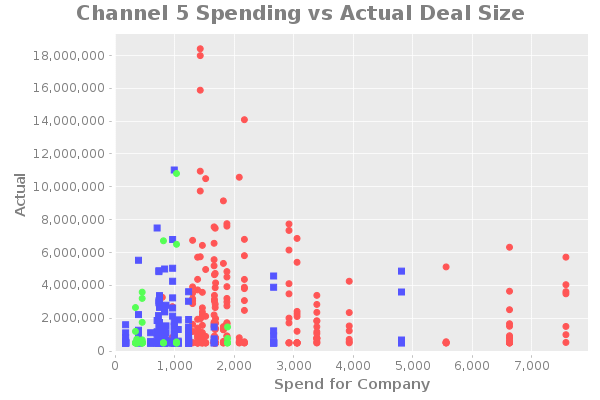

In [20]:
(-> (scatter-plot 
      ($ :channel_spend5 input-data)
      ($ :actual_deal_size input-data)
      :title "Channel 5 Spending vs Actual Deal Size"
      :x-label "Spend for Company"
      :y-label "Actual"
      :group-by ($ :industry_id input-data))
  (.createBufferedImage 600 400))

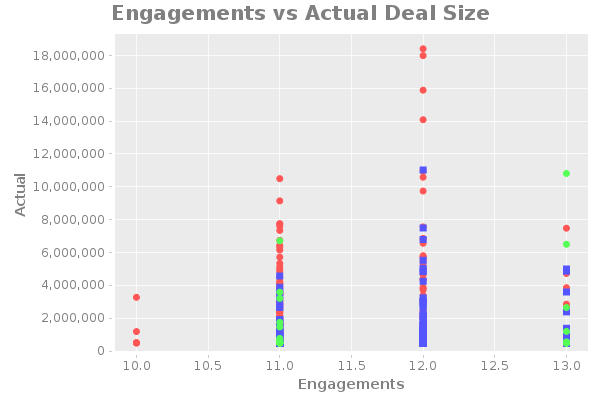

In [21]:
(-> (scatter-plot 
      ($ :num_engagements input-data)
      ($ :actual_deal_size input-data)
      :title "Engagements vs Actual Deal Size"
      :x-label "Engagements"
      :y-label "Actual"
      :group-by ($ :industry_id input-data))
  (.createBufferedImage 600 400))